In [3]:
from data.dataset import REFLACXWithClinicalDataset
from model.xami import XAMIMultiModal
import torch
from utils.train import split_dataset, train_with_auc_margin_loss


In [4]:
# checking if the GPU is available
use_gpu = torch.cuda.is_available()

# setting up the device
device = 'cuda' if use_gpu else 'cpu'

print(f"Will be using {device}")


Will be using cuda


In [5]:
# load the dataset
reflacx_dataset = REFLACXWithClinicalDataset(image_size=256)

# keep the architecture simple, so we check the image nn first.
# prepare the model
xami_mutlimodal = XAMIMultiModal(
    reflacx_dataset,
    device,
    use_clinical=True,
    model_dim=16, # was 64
    embeding_dim=64,
    dropout=.2,  # increase the dropout rate did improve the regularization.
    pretrained=True
)
xami_mutlimodal = xami_mutlimodal.to(device)


Positive Loss weight:
[0.768546   0.78635013 0.7937685  0.8338279  0.87388724]
Negative Loss weight:
[0.231454   0.21364985 0.20623146 0.1661721  0.12611276]
Random Loss:
0.21026036153991162


In [5]:
xami_mutlimodal.num_all_params()

7043895

In [6]:
batch_size = 64

dataloaders = split_dataset(
    reflacx_dataset,
    batch_size,
    traing_portion=.8,
    test_portion=.1,
    seed=123
)

In [7]:
# lr = 1e-2

# optimizer = optim.Adam(
#     xami_mutlimodal.parameters(),
#     lr=lr,
#     weight_decay=1e-6
# )

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                  patience=10,
#                                                  threshold=1e-3,
#                                                  factor=0.5
#                                                  )

# # scheduler = None


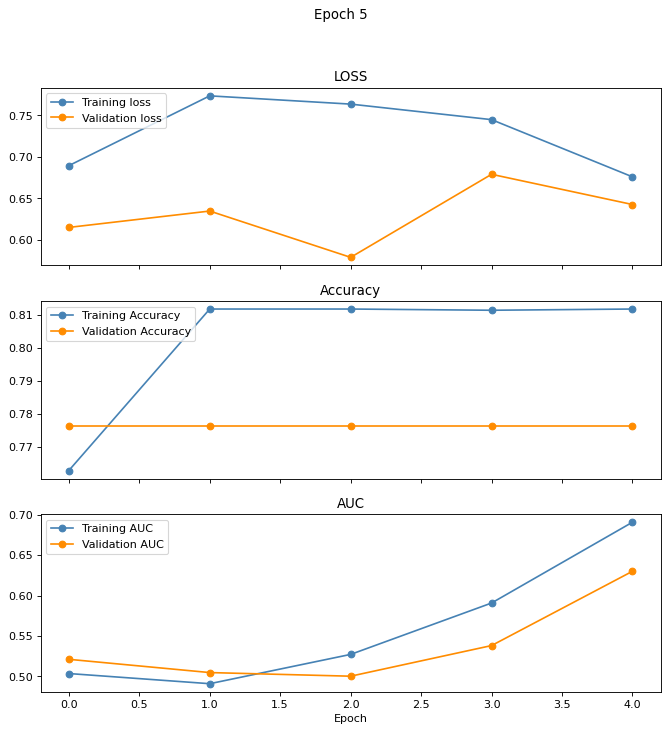


====================Current Learning Rate====================
| 0.1 

====================Training Result====================
| LOSS 0.6759 | ACC 0.8119 | AUC  0.6909 

| Training Confusion Matrix 

| Enlarged cardiac silhouette 
              Pred_False  Pred_True
Target_False         394         17
Target_True          112         16

| Atelectasis 
              Pred_False  Pred_True
Target_False         423          0
Target_True          116          0

| Pleural abnormality 
              Pred_False  Pred_True
Target_False         430          1
Target_True          107          1

| Consolidation 
              Pred_False  Pred_True
Target_False         445          6
Target_True           81          7

| Pulmonary edema 
              Pred_False  Pred_True
Target_False         472          0
Target_True           67          0

====================Validation Result====================
| LOSS 0.6426 | ACC 0.7765 | AUC  0.6302 

| Validation Confusion Matrix 

| Enlarged cardia

In [8]:
train_data_1, val_data_1, test_data_1 = train_with_auc_margin_loss(
    num_epochs=100,
    model=xami_mutlimodal,
    dataloaders=dataloaders,
    dataset=reflacx_dataset,
    device=device,
    lr=1e-1,
)


In [ ]:
xami_mutlimodal = XAMIMultiModal(
    reflacx_dataset,
    device,
    use_clinical=False,
    model_dim=16,
    embeding_dim=64,
    dropout=.2,  # increase the dropout rate did improve the regularization.
    pretrained=True
)
xami_mutlimodal = xami_mutlimodal.to(device)

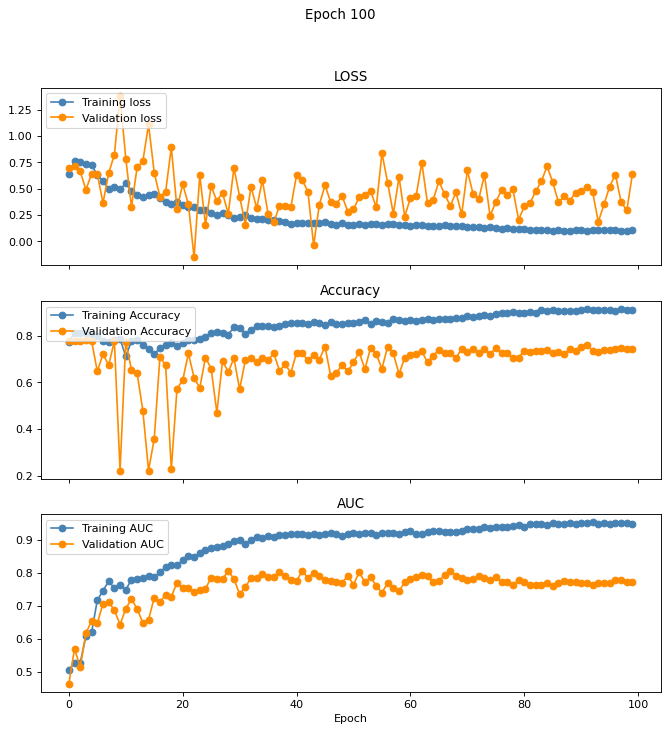


====================Current Learning Rate====================
| 0.02 

====================Training Result====================
| LOSS 0.1076 | ACC 0.9109 | AUC  0.9500 

| Training Confusion Matrix 

| Enlarged cardiac silhouette 
              Pred_False  Pred_True
Target_False         364         47
Target_True            2        126

| Atelectasis 
              Pred_False  Pred_True
Target_False         377         46
Target_True            1        115

| Pleural abnormality 
              Pred_False  Pred_True
Target_False         405         26
Target_True            6        102

| Consolidation 
              Pred_False  Pred_True
Target_False         420         31
Target_True            0         88

| Pulmonary edema 
              Pred_False  Pred_True
Target_False         392         80
Target_True            1         66

====================Validation Result====================
| LOSS 0.6426 | ACC 0.7441 | AUC  0.7730 

| Validation Confusion Matrix 

| Enlarged cardi

In [ ]:
train_data_2, val_data_2, test_data_2 = train_with_auc_margin_loss(
    num_epochs=100,
    model=xami_mutlimodal,
    dataloaders=dataloaders,
    dataset=reflacx_dataset,
    device=device,
    lr=1e-1,
)

In [ ]:
# train_data, val_data = train_with_auc_margin_loss(
#     num_epochs=300,
#     model=xami_mutlimodal,
#     dataloaders=dataloaders,
#     lr=0.1,
#     dataset=reflacx_dataset,
#     device=device,
# )

# # if overfitting

# # Try


In [ ]:
# train_data, val_data = train_with_auc(
#     num_epochs=300,
#     model=xami_mutlimodal,
#     dataloaders=dataloaders,
#     lr=1e-1,
#     dataset=reflacx_dataset,
#     device=device,
#     early_stop_count=None,
#     using_scheduler=False,
# )

# # if overfitting

# # Try
